### 04 — Neural Collaborative Filtering (NCF / MLP)
Train a PyTorch MLP-based recommender using the processed splits:
`data/processed/ratings_train.csv`, `ratings_valid.csv`, `ratings_test.csv`.

**Notes**
- We build user/item id maps from the **union** of all splits to keep indices consistent.
- Model: user & item embeddings → MLP → rating (regression).
- Metrics: RMSE, MAE on validation & test.
- Works on CPU, CUDA.

In [1]:
from pathlib import Path
import sys

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))

from ncf_model import (
    build_ncf_model,
    encode_splits,
    RatingsDataset,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [2]:
train_df = pd.read_csv(PROC / "ratings_train.csv")
valid_df = pd.read_csv(PROC / "ratings_valid.csv")
test_df  = pd.read_csv(PROC / "ratings_test.csv")

for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"{name} -> shape={df.shape}  users={df.userId.nunique()}  items={df.movieId.nunique()}")


train -> shape=(31316, 7)  users=479  items=426
valid -> shape=(3669, 7)  users=479  items=426
test -> shape=(3669, 7)  users=479  items=426


In [3]:
# Encodes raw IDs (like userId, movieId) into integer indices used by models.
train_enc, valid_enc, test_enc, user2idx, item2idx = encode_splits(train_df, valid_df, test_df)
user2idx_map = user2idx.to_dict()
item2idx_map = item2idx.to_dict()

n_users = len(user2idx)
n_items = len(item2idx)
print('n_users:', n_users, 'n_items:', n_items)


n_users: 479 n_items: 426


In [4]:
BATCH_SIZE = 2048
# Wrap DataFrames into PyTorch Datasets
train_dataset = RatingsDataset(train_enc)
valid_dataset = RatingsDataset(valid_enc)
test_dataset = RatingsDataset(test_enc)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [5]:
# Define Training Hyperparameters
EPOCHS = 10 # Number of full passes through the training data
LR = 0.001 # Learning rate for the optimizer
EMB = 64 # Size of user/item embedding vectors in the NCF model

# Build Model, Loss Function, and Optimizer
model = build_ncf_model(n_users, n_items, emb_dim=EMB, device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Initialize Training State Tracking
history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
best_val = float('inf')
best_ep = None

model_path = BASE / 'models' / 'ncf_best.pth'
model_path.parent.mkdir(parents=True, exist_ok=True)

# Main Training Loop
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_rmse, tr_mae = run_epoch(model, train_loader, criterion, optimizer, device=device)
    val_loss, val_rmse, val_mae = run_epoch(model, valid_loader, criterion, optimizer=None, device=device)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)

    print(f'Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_RMSE={val_rmse:.4f}  val_MAE={val_mae:.4f}')

    # Save Best val
    if val_rmse < best_val:
        best_val = val_rmse
        best_ep = ep
        torch.save(model.state_dict(), model_path)

print('Best val RMSE:', best_val, 'at epoch', best_ep)


Epoch 01 | train_loss=14.5580  val_loss=13.2338  val_RMSE=3.6401  val_MAE=3.5089
Epoch 02 | train_loss=12.0013  val_loss=7.7643  val_RMSE=2.7891  val_MAE=2.6273
Epoch 03 | train_loss=3.7359  val_loss=1.4590  val_RMSE=1.2057  val_MAE=0.9396
Epoch 04 | train_loss=1.6076  val_loss=0.9025  val_RMSE=0.9532  val_MAE=0.7673
Epoch 05 | train_loss=1.2553  val_loss=0.7425  val_RMSE=0.8637  val_MAE=0.6716
Epoch 06 | train_loss=1.1962  val_loss=0.7243  val_RMSE=0.8526  val_MAE=0.6564
Epoch 07 | train_loss=1.1538  val_loss=0.7329  val_RMSE=0.8579  val_MAE=0.6658
Epoch 08 | train_loss=1.1032  val_loss=0.7266  val_RMSE=0.8540  val_MAE=0.6611
Epoch 09 | train_loss=1.0749  val_loss=0.7223  val_RMSE=0.8513  val_MAE=0.6573
Epoch 10 | train_loss=1.0381  val_loss=0.7271  val_RMSE=0.8542  val_MAE=0.6625
Best val RMSE: 0.8513146638870239 at epoch 9


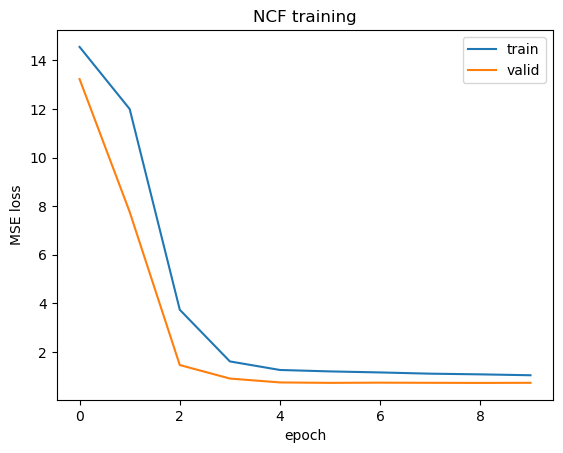

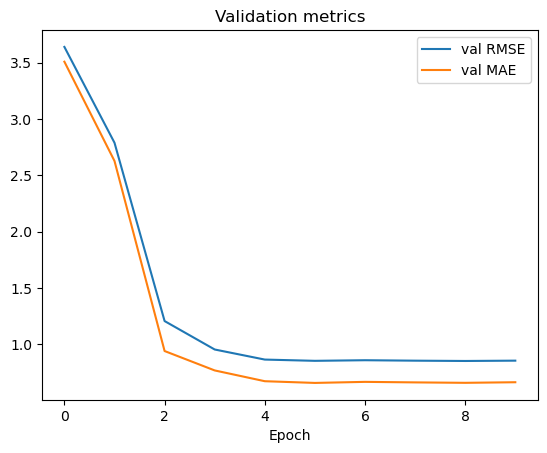

In [6]:
plt.figure()
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.xlabel('epoch'); plt.ylabel('MSE loss'); plt.legend(); plt.title('NCF training'); plt.show()

plt.figure()
plt.plot(history['val_rmse'], label='val RMSE'); plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('Epoch'); plt.legend(); plt.title('Validation metrics'); plt.show()


In [7]:
# Load the Best Model Weights
model.load_state_dict(torch.load(model_path, map_location=device))
# Evaluate the Model on Test Data
test_loss, test_rmse, test_mae = run_epoch(model, test_loader, criterion, optimizer=None, device=device)
print(f'Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}')


Test RMSE: 0.8868 | Test MAE: 0.6834


In [8]:
# Build “seen” items mapping
train_seen = build_seen_items(train_df)
movies_meta = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df.userId.sample(1, random_state=42).iloc[0])
# Generate Top-K recommendations
topk = recommend_topk(
    model,
    sample_user,
    user2idx=user2idx_map,
    item2idx=item2idx_map,
    train_seen=train_seen,
    k=10,
    device=device,
).merge(movies_meta, on='movieId', how='left').loc[:, ["movieId", "title", "genres", "pred_rating"]]

print('Sample user:', sample_user)
display(topk)


Sample user: 591


,movieId,title,genres,pred_rating
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.405581
1,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,4.374725
2,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.360790
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.331543
4,1199,Brazil (1985),Fantasy|Sci-Fi,4.319302
5,904,Rear Window (1954),Mystery|Thriller,4.284191
6,858,"Godfather, The (1972)",Crime|Drama,4.271798
7,1148,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime,4.261241
8,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.255569
9,1225,Amadeus (1984),Drama,4.249712
